# Stock Portfolio Optimisation Tool Using Artificial Intelligence
## Thomas Lowe

In [1]:
%load_ext watermark
%load_ext tensorboard

In [36]:
#loads required packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import ipywidgets as w
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
from math import sqrt
import csv

In [3]:
def display_widget():
    print ("\nPlease enter the dates you wish to retrieve stock data from")
    #Declare the widgets as global variables so they can be used in the next function
    global start_date_widget, end_date_widget
    start_date_widget = w.DatePicker(description='Start Date')
    end_date_widget = w.DatePicker(description='End Date')
    #Displays the widget datepicker that was just created
    display(start_date_widget, end_date_widget)

In [4]:
def date_from_widget():
    #converts the dates into strings
    start_date = str(start_date_widget.value)
    end_date = str(end_date_widget.value)
    return start_date, end_date

# Markowitz

In [6]:
#companylist.csv is made from a list of nasdaq listed companies as of 09/04/2020
#ftp://ftp.nasdaqtrader.com/symboldirectory
companylist = []
with open('companylist.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        companylist.append(row[0])

In [7]:
tickers = []
conditional = input("Would you like to use the placeholder tickers? Type 'n' to use your own.\n Any other entry will use placeholders.").lower()

if conditional == ("n"):
    counter = 0
    while counter != 1:
        firstTicker = input("\nPlease enter the first ticker here. I.e. AAPL.").upper()
        if firstTicker in companylist:
            tickers.append(firstTicker)
            counter = counter+1
        else:
            print (firstTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 2:
        secondTicker = input("Please enter the second ticker here. I.e. FB.").upper()
        if secondTicker in companylist:
            tickers.append(secondTicker)
            counter = counter+1
        else:
            print (secondTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 3:
        thirdTicker = input("Please enter the third ticker here. I.e. TSLA.").upper()
        if thirdTicker in companylist:
            tickers.append(thirdTicker)
            counter = counter+1
        else:
            print (thirdTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 4:
        fourthTicker = input("Please enter the fourth ticker here. I.e. MSFT.").upper()
        if fourthTicker in companylist:
            tickers.append(fourthTicker)
            counter = counter+1
        else:
            print (fourthTicker+" is not a valid ticker. Please enter a valid ticker.")
    print ("You have entered the following "+str(tickers))
else:
    #Declares the stock tickers that are to be used
    #Tickers are a stocks unique identifier
    tickers = ['FB','AAPL','TSLA','BP']
    
#Uses the tickers to get information from YahooFinancials package
yahoo_financials = yf(tickers)
display_widget()

Would you like to use the placeholder tickers? Type 'n' to use your own.
 Any other entry will use placeholders.y

Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [8]:
date_from_widget()
#Pulls the start_date, end_date variables from the date_from_widget function
start_date,end_date = date_from_widget()
print(start_date,end_date)

2001-01-01 2020-01-01


In [9]:
data = yahoo_financials.get_historical_price_data(start_date,end_date,'daily')

prices_df = pd.DataFrame({
        asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in tickers
})

prices_df.index.name="Formatted_Date"
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.head()

,FB,AAPL,TSLA,BP
Formatted_Date,,,,
2012-05-18,38.230000,65.770210,27.559999,23.393652
2012-05-21,34.029999,69.601997,28.770000,23.778296
2012-05-22,31.000000,69.067520,30.799999,23.866570
2012-05-23,32.000000,70.752777,31.020000,23.910711
2012-05-24,33.029999,70.102989,30.280001,24.106182


Text(0.5, 0, 'Date')

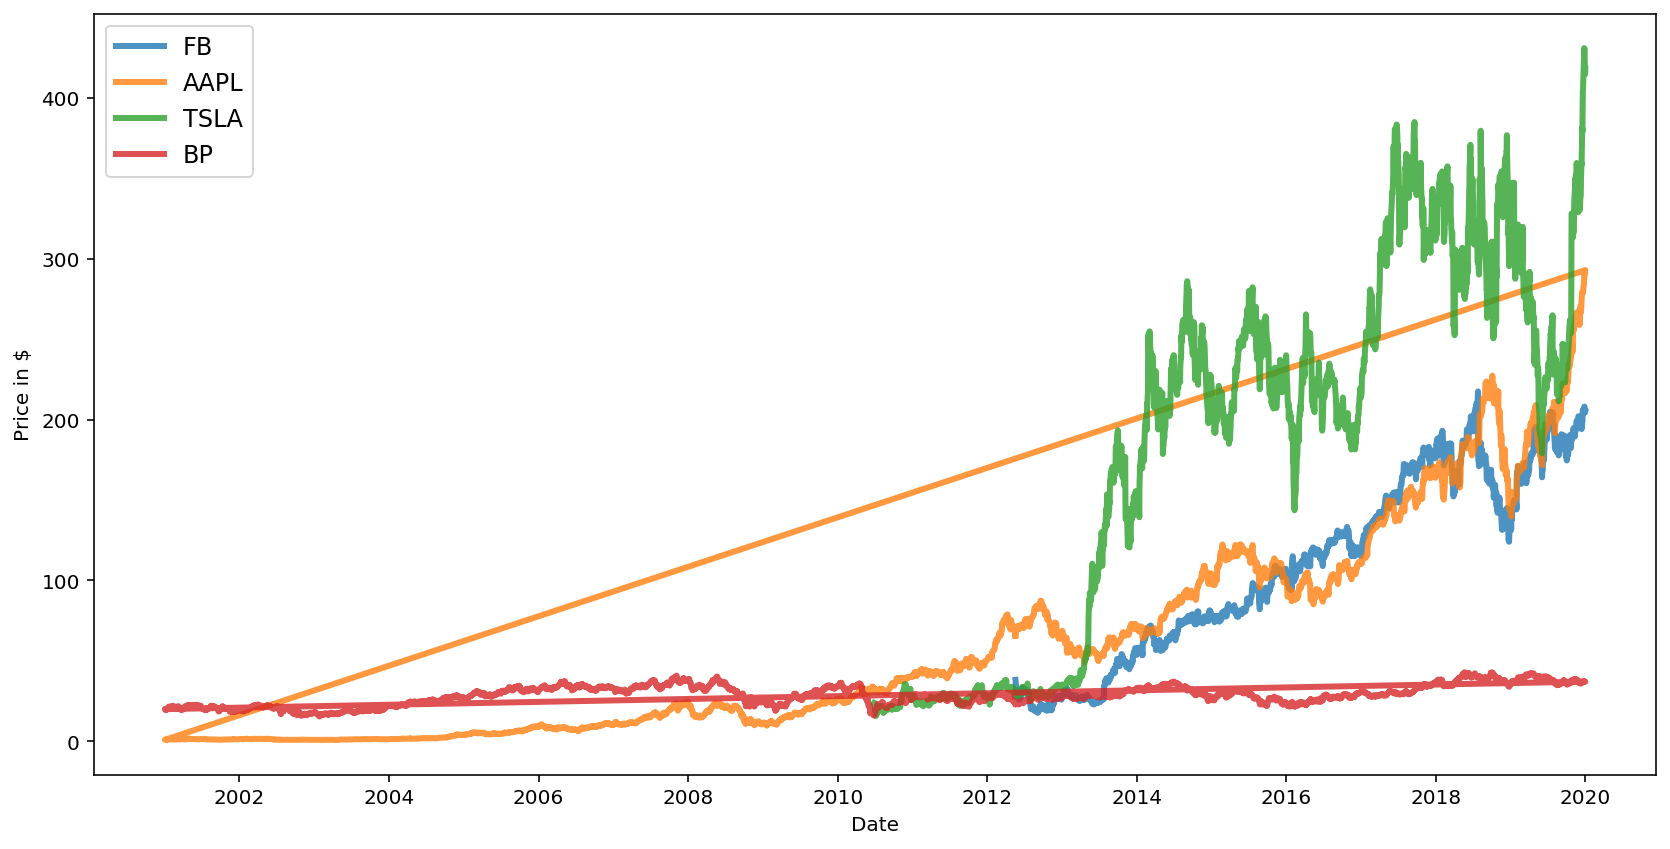

In [10]:
plt.figure(figsize=(14,7))
for c in prices_df.columns.values:
    plt.plot(prices_df.index,prices_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

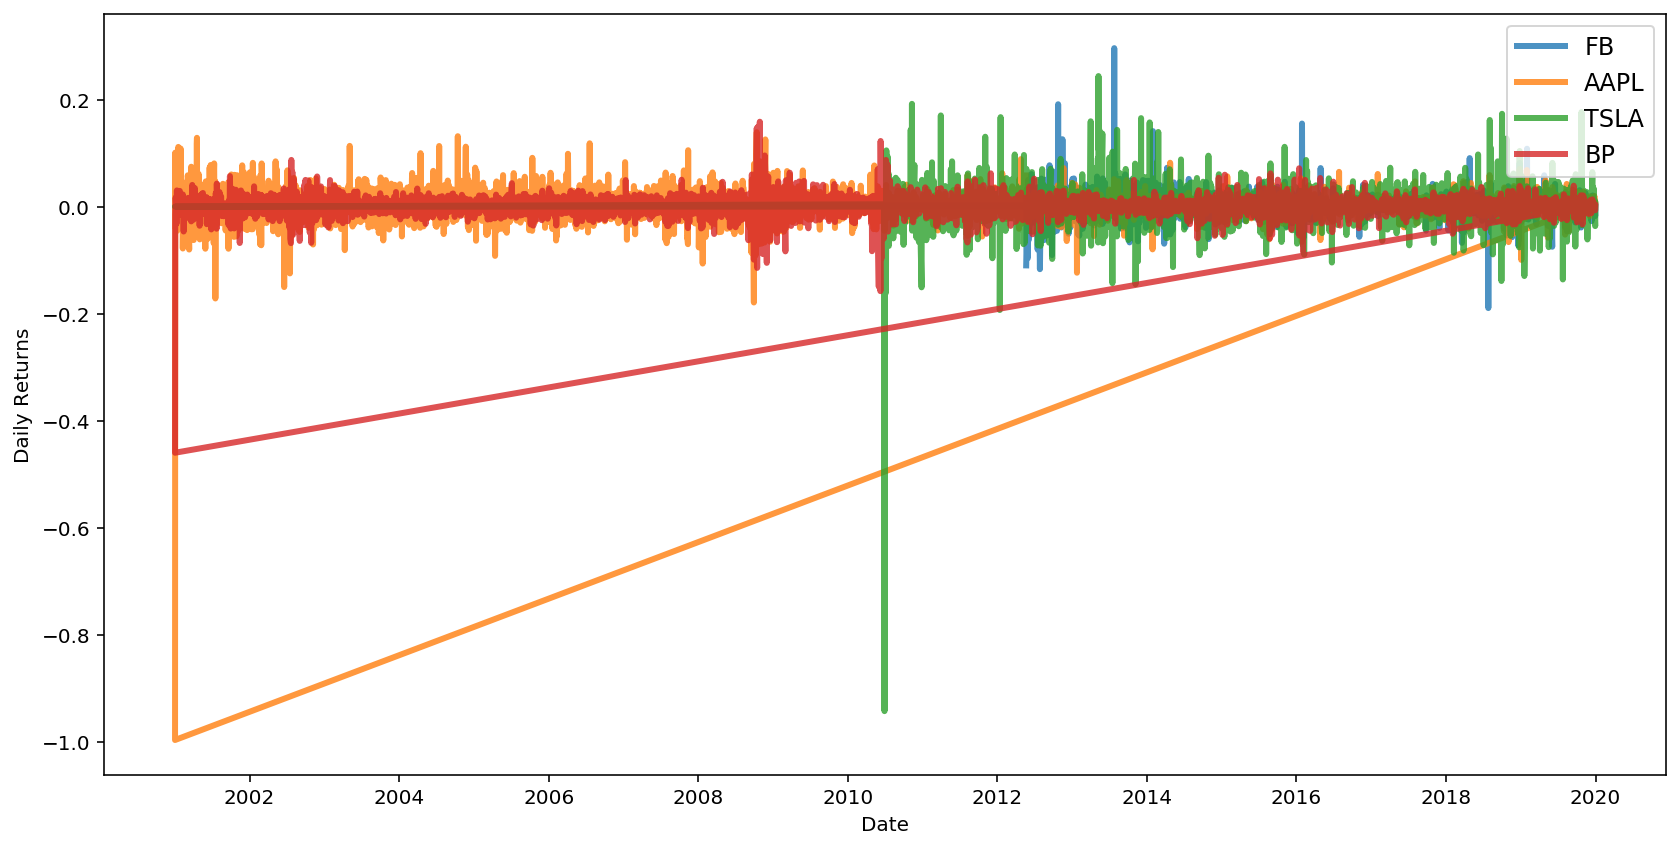

In [11]:
returns = prices_df.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right',fontsize=12)
plt.ylabel('Daily Returns')
plt.xlabel('Date')

In [12]:
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    #252 represents the number of trading days in a year
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [13]:
returns = prices_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [14]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=prices_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]

    max_sharpe_allocation.allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print (prices_df)

    

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.24


               FB  AAPL   TSLA    BP
allocation  40.48  44.7  14.68  0.14
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.11
Annualised Volatility: 0.18


               FB  AAPL   TSLA     BP
allocation  55.17  6.01  11.38  27.44
                       FB       AAPL       TSLA         BP
Formatted_Date                                            
2012-05-18      38.230000  65.770210  27.559999  23.393652
2012-05-21      34.029999  69.601997  28.770000  23.778296
2012-05-22      31.000000  69.067520  30.799999  23.866570
2012-05-23      32.000000  70.752777  31.020000  23.910711
2012-05-24      33.029999  70.102989  30.280001  24.106182
...                   ...        ...        ...        ...
2012-05-11            Na

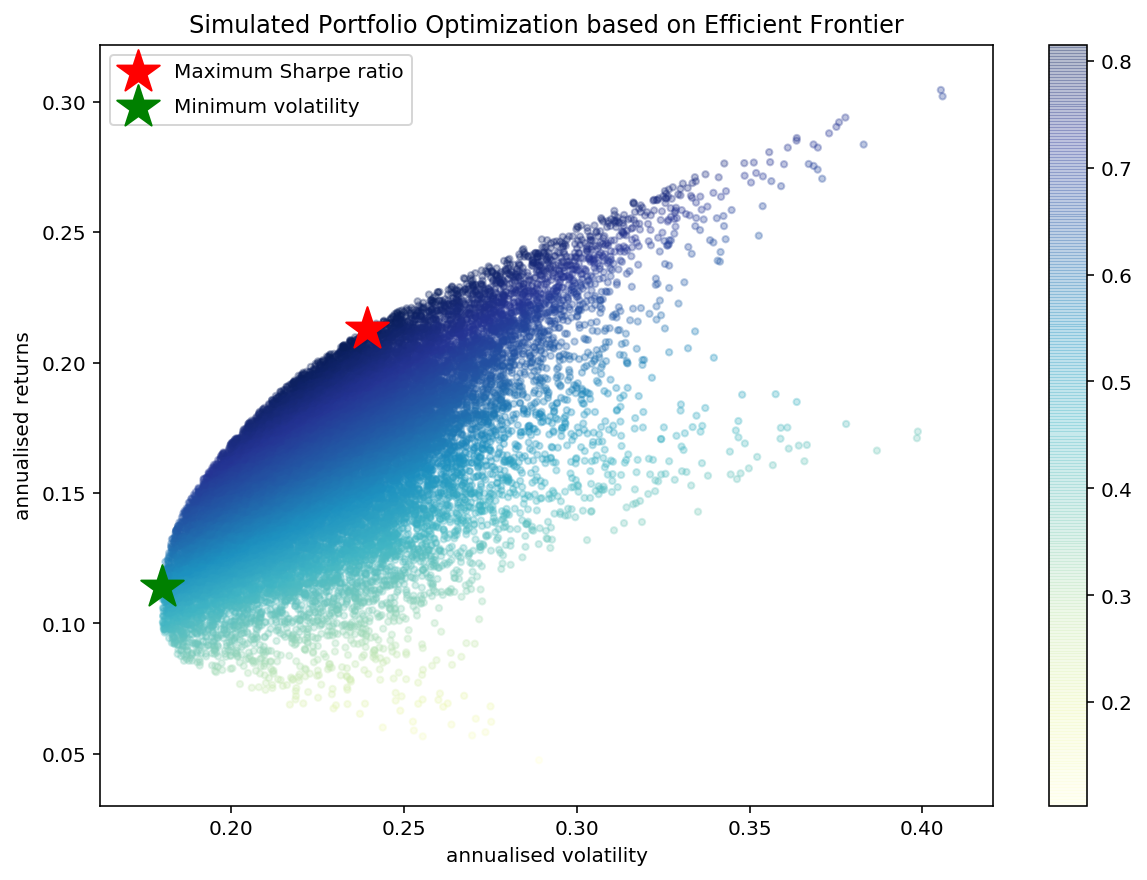

In [15]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Algorithm

In [16]:
display_widget()


Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [79]:
date_from_widget()
start_date,end_date = date_from_widget()
print(start_date,end_date)

2001-01-01 2020-01-01


In [80]:
while True:
    ticker = input("Please enter a ticker here. I.e. BP.").upper()
    if ticker in companylist:
        yahoo_finacials = yf(ticker)
        break
    else:
        print ("\n'"+ticker+"' is not a valid ticker, please try again.")
data = yahoo_finacials.get_historical_price_data(start_date, end_date, "daily")
print ("\nThe ticker you have selected is '"+ticker+"'.")

Please enter a ticker here. I.e. BP.MSFT

The ticker you have selected is 'MSFT'.


In [81]:
userInput_df = pdr.get_data_yahoo(ticker,
                          start_date,
                          end_date
                          )
userInput_df.head()
userInput_df=userInput_df.Close
userInput_df.head()

Date
2001-01-02    21.68750
2001-01-03    23.96875
2001-01-04    24.21875
2001-01-05    24.56250
2001-01-08    24.46875
Name: Close, dtype: float64

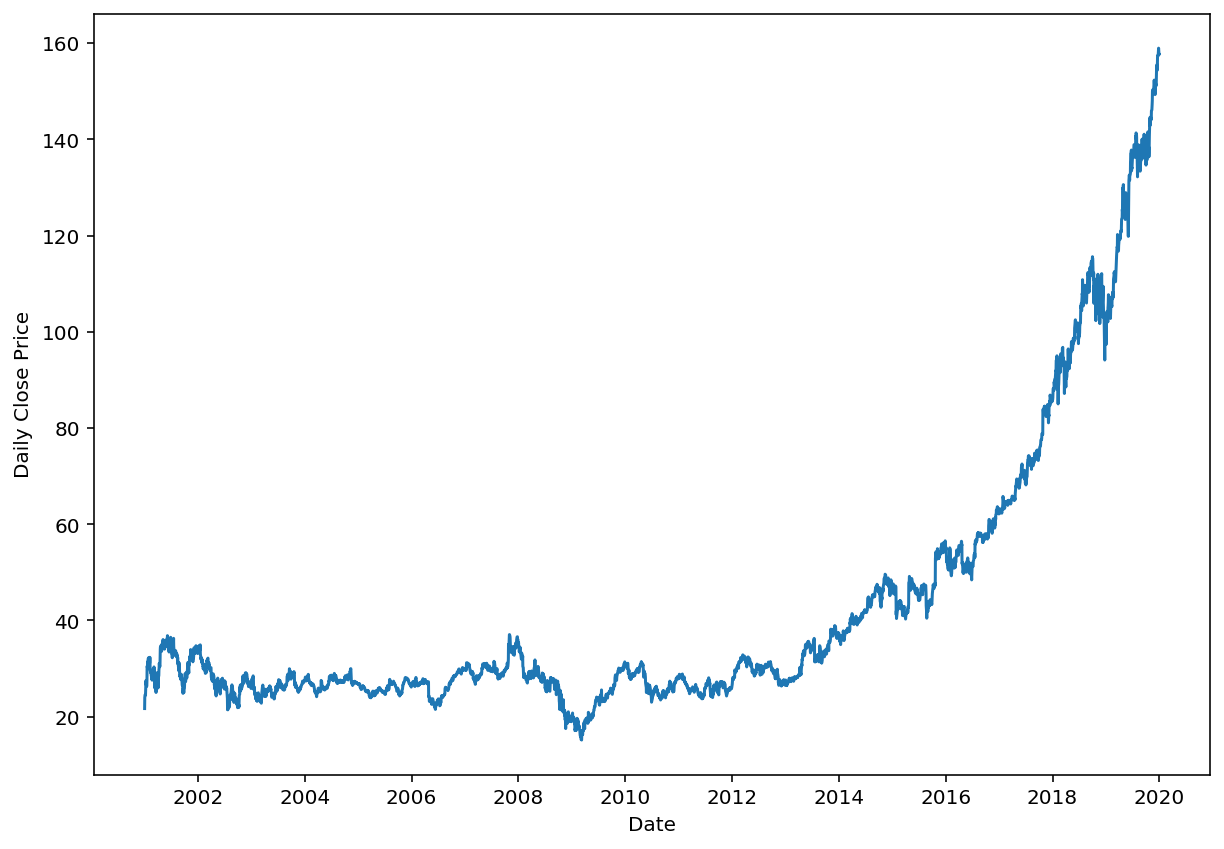

In [82]:
plt.figure(figsize=(10, 7))
plt.plot(userInput_df)
plt.ylabel('Daily Close Price')
plt.xlabel('Date')
plt.show()

In [83]:
X = userInput_df.values
train_size = int(len(X)*0.66)
train, test = X[1:train_size], X[train_size:]

RMSE: 1.104


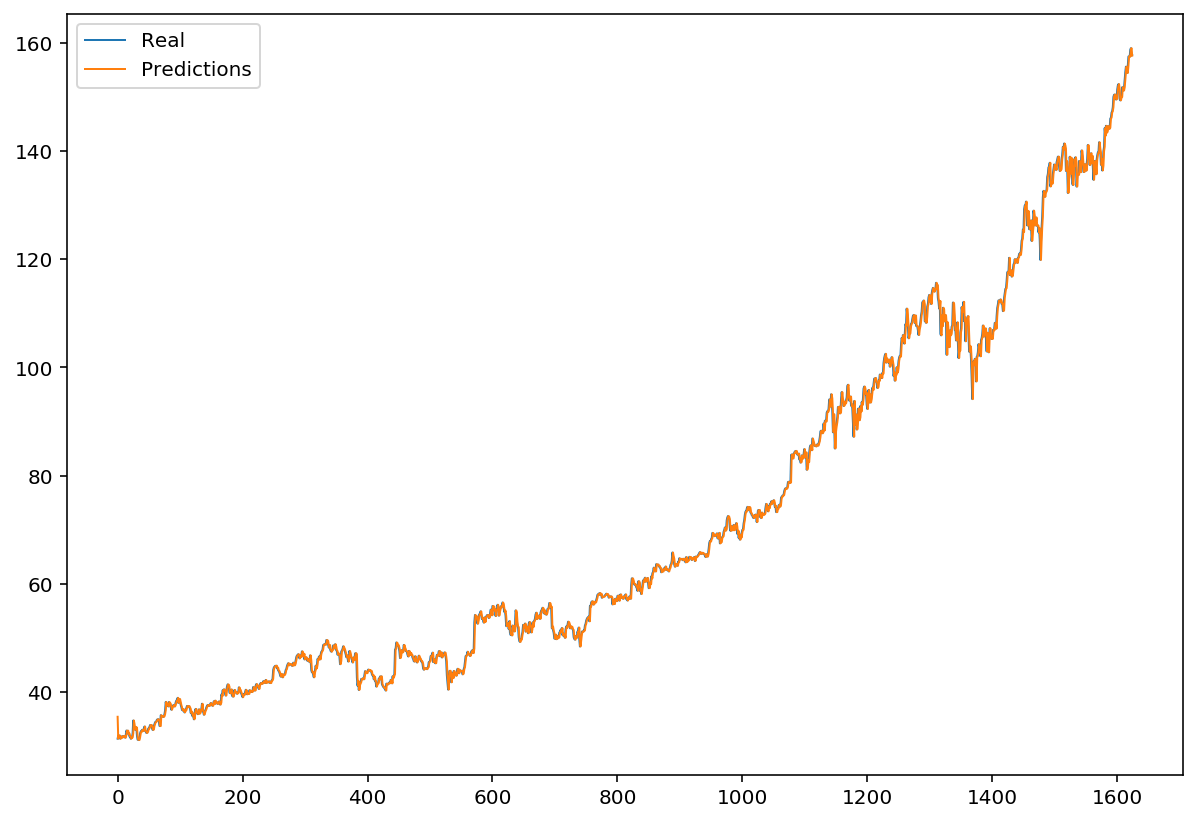

In [84]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])
#This is the percentage that the predictions deviate from the actual values
#Close rmse is to 0, the more accurate the model is
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(10, 7))
plt.plot(test, label='Real', linewidth=1)
plt.plot(predictions, label='Predictions', linewidth=1)
plt.legend(['Real','Predictions'])
plt.show()

In [85]:
y_train = train
y_valid = test

In [86]:
x_train=x_train.reshape(-1,1)
x_valid=x_valid.reshape(-1,1)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [87]:
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [88]:
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print('RMSE: %.3f' % rms)

RMSE: 55.097


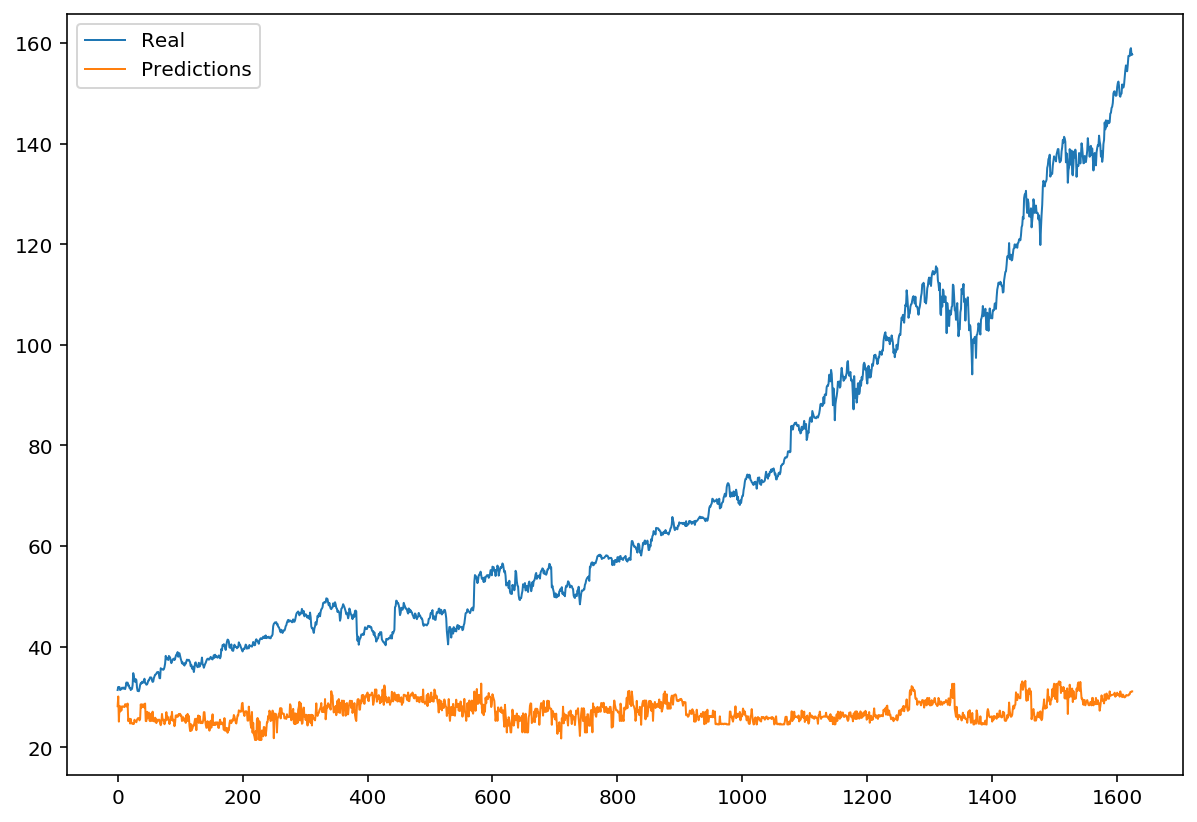

In [89]:
plt.figure(figsize=(10, 7))
plt.plot(test, label='Real', linewidth=1)
plt.plot(preds, label='Predictions', linewidth=1)
plt.legend(['Real','Predictions'])
plt.show()